# Features Analysis

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('seaborn-ticks')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18
sns.set_style("ticks")

In [2]:
ds = pd.read_csv('data/wdds.csv')
ds.shape

(2097, 20)

remove unnecesary label 'discusión' in title

In [3]:
ds['page_title'] = ds.page_title.str.replace('Discusión:', '')

In [4]:
print(f'unique authors: {ds.contributor.nunique()}')

unique authors: 387


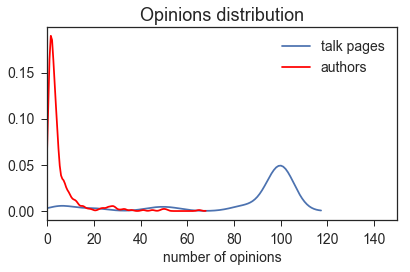

In [5]:
discussion_perpage= ds.groupby('page_title').size()
discussion_pereditor= ds.groupby('contributor').size()
sns.kdeplot(discussion_perpage,label='talk pages')
plt.xlabel('number of opinions')
sns.kdeplot(discussion_pereditor,color='red', label='authors')
plt.title('Opinions distribution')
plt.xlim([0,150])
plt.tight_layout()
plt.savefig('output/opauthorcontribdist.eps', format='eps')

In [6]:
import scipy.stats as stats
import scipy
print(stats.normaltest(np.log(discussion_perpage)))
print(scipy.stats.mstats.skew(discussion_perpage))

NormaltestResult(statistic=26.549266604121378, pvalue=1.7175128998289259e-06)
-1.7207740848065967


Most authors have 10 or less opinions.  It could be useful to know if there are authors with opinions in multiple talk pages

In [7]:
discussion_editor=ds.groupby(['contributor', 'page_title']).size().reset_index()
discussion_editor=discussion_editor['contributor'].value_counts()
discussion_editor=discussion_editor.reset_index() #.plot.area()
discussion_editor.columns=['contributors', 'pages']
discussion_editor=discussion_editor.groupby('pages').count().reset_index()
total=discussion_editor.contributors.sum()
discussion_editor['perc'] = discussion_editor.contributors / total
discussion_editor.to_csv('output/articlesauthorcontribdist.csv', index=False)
discussion_editor

,pages,contributors,perc
0,1,358,0.925065
1,2,22,0.056848
2,3,3,0.007752
3,4,2,0.005168
4,7,2,0.005168


## temporality

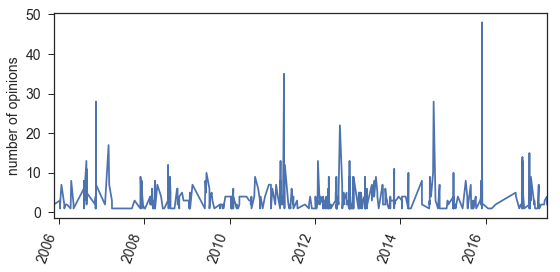

In [8]:
ds['page_title'] = ds.page_title.str.replace('Discusión:', '')
ds['created_date'] = pd.to_datetime(ds.creation_dt)
plt.figure(figsize=(8,4))
ts = ds.groupby(['created_date']).size()
ts.plot()
plt.xticks(rotation=70)
plt.xlabel('')
plt.ylabel('number of opinions')
plt.tight_layout()
plt.savefig('output/temporalauthorcontribdist.eps', format='eps',bbox_inches='tight')

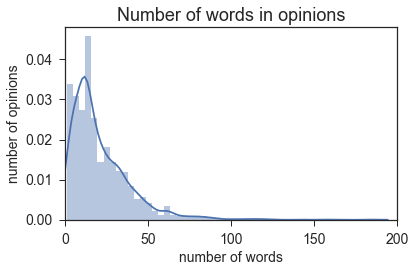

In [9]:
from nltk.tokenize import word_tokenize

ds['opinion'] = ds['clean_opinion']
ds.opinion.fillna(value='', inplace=True)
ds['opnumwords'] = ds.opinion.apply(lambda s: len(word_tokenize(s, 'spanish')))

sns.distplot(ds.opnumwords)
plt.xlabel('number of words')
plt.ylabel('number of opinions')
plt.title('Number of words in opinions')
plt.xlim([0, 200])
plt.tight_layout()
plt.savefig('output/numwordsopdist.eps', format='eps')

as expected the distribution of length of words is very similar to characters in opinions. Although there are opinions with only one word, it may be useful to know what kind of opinions are those:

In [10]:
ds[ds.opnumwords<2].opinion.value_counts().head()

saludos     9
saludos     5
.           4
gracias     3
fuente      2
Name: opinion, dtype: int64

In [11]:
import datetime
import wdds_tokenizer
from wdds_tokenizer import tokenize

words = ' '.join(ds[(ds.created_date>datetime.date(2015,1,1))
                   &(ds.created_date<datetime.date(2017,1,1))].opinion)

word_list = word_tokenize(words)
word_list = [word for word in word_list if word not in wdds_tokenizer.stopset]
print(f'number of words with simple tokenization: {len(word_list)}')

use_stemmer=True
word_list = tokenize(words)
word_list = [word for word in word_list if word not in wdds_tokenizer.stopset]
print(f'number of words with stemming removal: {len(word_list)}')

use_stemmer=False
word_list = tokenize(words)
word_list = [word for word in word_list if word not in wdds_tokenizer.stopset]
print(f'number of words with stop words removal: {len(word_list)}')


wds = pd.DataFrame(word_list)
wds.columns = ['word']
wds=wds.word.value_counts().reset_index()
wds.columns=['word', 'count']
wds=wds[(wds['count']>2) & (wds['count']<10)]
print(f'number of words (TF min:3): {len(wds)}')


number of words with simple tokenization: 4725
number of words with stemming removal: 3314
number of words with stop words removal: 3314
number of words (TF min:3): 171


In [12]:
wds.sort_values('count', ascending=False).head()

,word,count
23,procesado,9
25,elegido,9
26,puede,9
27,elección,9
24,dice,9


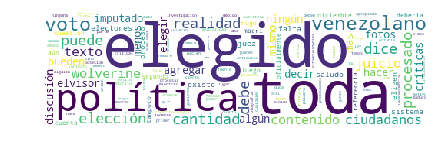

In [13]:
from wordcloud import WordCloud
filtered_words = ' '.join(wds.word)
wordcloud = WordCloud(background_color='white', width=500, height=150).generate(filtered_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0,h_pad=0, w_pad=0)
plt.savefig('output/wordcloud.png',bbox_inches='tight')